<ipython-input-2-15033b40a94c>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor.drop('ID', axis=1, inplace=True)


              precision    recall  f1-score   support

           0       0.84      0.94      0.89      6505
           1       0.65      0.37      0.47      1916

    accuracy                           0.81      8421
   macro avg       0.74      0.66      0.68      8421
weighted avg       0.79      0.81      0.79      8421

0.8115425721410758


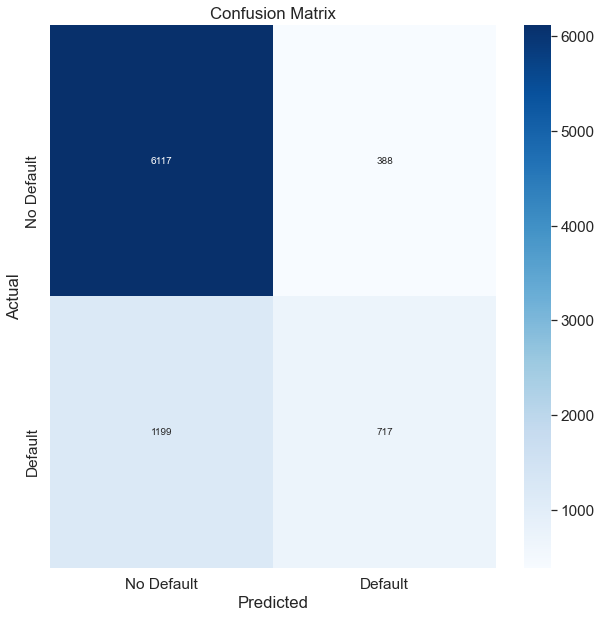

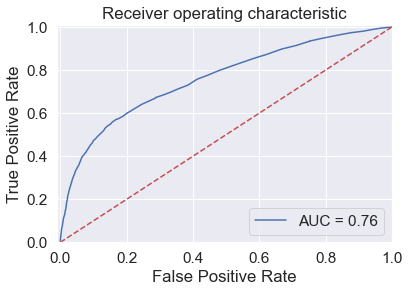

In [2]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

credit_card_data = pd.read_csv('UCI_Credit_Card.csv')

# remove the rows with negative bill amount
credit_card_data = credit_card_data[credit_card_data['BILL_AMT1'] >= 0]
credit_card_data = credit_card_data[credit_card_data['BILL_AMT2'] >= 0]
credit_card_data = credit_card_data[credit_card_data['BILL_AMT3'] >= 0]
credit_card_data = credit_card_data[credit_card_data['BILL_AMT4'] >= 0]
credit_card_data = credit_card_data[credit_card_data['BILL_AMT5'] >= 0]
credit_card_data = credit_card_data[credit_card_data['BILL_AMT6'] >= 0]

GenderMap = {2:'female', 1:'male'}
MarriageMap = {1:'married', 2:'single', 3: 'other', 0:'other2'}
EducationMap = {1:'graduate school', 2:'university', 3:'high school', 4: 'other', 5:'unkown', 6:'unkown', 0:'unkown'}

credit_card_data['SEX'] = credit_card_data['SEX'].map(GenderMap)
credit_card_data['MARRIAGE'] = credit_card_data['MARRIAGE'].map(MarriageMap)
credit_card_data['EDUCATION'] = credit_card_data['EDUCATION'].map(EducationMap)

# dummify each of the variables
credit_card_data['PAY_0'] = credit_card_data['PAY_0'].astype(str)
credit_card_data['PAY_2'] = credit_card_data['PAY_2'].astype(str)
credit_card_data['PAY_3'] = credit_card_data['PAY_3'].astype(str)
credit_card_data['PAY_4'] = credit_card_data['PAY_4'].astype(str)
credit_card_data['PAY_5'] = credit_card_data['PAY_5'].astype(str)
credit_card_data['PAY_6'] = credit_card_data['PAY_6'].astype(str)

# getting the target and predictor models
target = credit_card_data['default.payment.next.month']
predictor = credit_card_data.iloc[:,credit_card_data.columns!='default.payment.next.month']
predictor.drop('ID', axis=1, inplace=True)

# get all categorical variables and dumify them
categorical_columns = [col for col in predictor.columns.values if predictor[col].dtype=='object']

# create another data frame with only the columns that we want
df_categorical = predictor[categorical_columns]

# values that are not needed to be dummified
df_numerical = predictor.drop(categorical_columns, axis=1)

# don't need all of them, need only 1 less than all of them
dummy_code_cat_vars = pd.get_dummies(df_categorical, drop_first=True)

# combine the variables back 
df_predictor = pd.concat([df_numerical, dummy_code_cat_vars], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_predictor, target, test_size = 0.3, random_state =0)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

X_train_scaled.columns = X_train.columns.values
X_test_scaled.columns = X_test.columns.values

X_train_scaled.index = X_train.index.values
X_test_scaled.index = X_test.index.values

def confusion_mat(y_test, y_pred):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    # data['cnf_mat'] = cnf_matrix

    # make confusion matrix look better
    cf_df = pd.DataFrame(cnf_matrix, index = [i for i in ['No Default', 'Default']], columns = [i for i in ['No Default', 'Default']])
    sns.set(font_scale=1.4)
    plt.figure(figsize=(10,10))
    sns.heatmap(cf_df, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
def create_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    # data['auc'] = auc
    plt.plot(fpr, tpr, label='AUC = %0.2f' % auc)
    # plot accuracy score
    # plt.plot(fpr, tpr, label='Accuracy = %0.2f' % accuracy_score)
    # print(accuracy_score)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

def main(y_test, model):
    y_pred = model.predict(X_test_scaled)
    
    # builds a classification report
    clf = classification_report(y_test, y_pred)
    # data['clf'] = clf
    print(clf)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)
    
    # builds the confusion matrix
    confusion_mat(y_test, y_pred)
    
    y_pred_proba = model.predict_proba(X_test_scaled)[:,1]
    
    # creating the roc cuurve with the roc_auc_score
    create_roc_curve(y_test, y_pred_proba)

classifier = RandomForestClassifier(n_estimators=100, random_state=0)
model_RF = classifier.fit(X_train_scaled, y_train)
main(y_test, model_RF)

In [22]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

predicted_no_default = []
predicted_default = []
accuracy = []
auc_lst = []

classifier = RandomForestClassifier(n_estimators=100, random_state=0)
model_RF = classifier.fit(X_train_scaled, y_train)

classifier = xgb.XGBClassifier(n_estimators=100, random_state=0)
model_XGB = classifier.fit(X_train_scaled, y_train)

classifier = LogisticRegression()
model_LR = classifier.fit(X_train_scaled, y_train)

classifier = DecisionTreeClassifier()
model_DT = classifier.fit(X_train_scaled, y_train)

classifier = KNeighborsClassifier(n_neighbors=5)
model_KNN = classifier.fit(X_train_scaled, y_train)

classifier = SVC()
model_SVM = classifier.fit(X_train_scaled, y_train)

models = [model_RF, model_LR, model_KNN, model_DT, model_SVM, model_XGB, ]

for model in models:
    y_pred = model.predict(X_test_scaled)

    cnf_matrix = confusion_matrix(y_test, y_pred)
    cf_df = pd.DataFrame(cnf_matrix, index = [i for i in ['No Default', 'Default']], columns = [i for i in ['No Default', 'Default']])
    predicted_no_default.append(cf_df['No Default'][0])
    predicted_default.append(cf_df['Default'][1])

    accuracy.append(accuracy_score(y_test, y_pred))

    auc = roc_auc_score(y_test, y_pred)
    auc_lst.append(auc)


/Users/vedanshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vedanshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


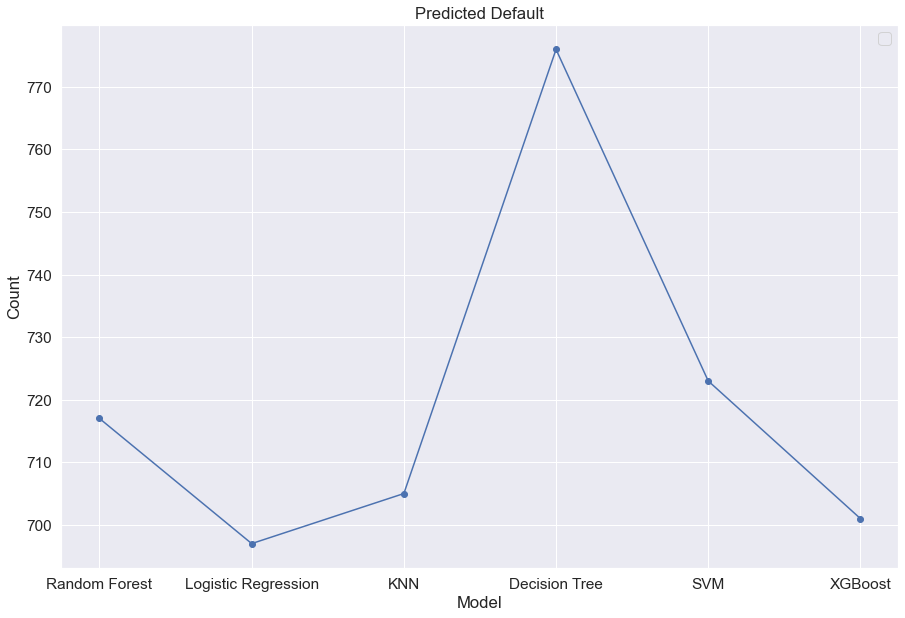

In [35]:
# plot the predicted_no_default, predicted_default, accuracy, auc_lst
plt.figure(figsize=(15,10))
plt.plot(['Random Forest', 'Logistic Regression', 'KNN', 'Decision Tree', 'SVM', 'XGBoost'], predicted_default, marker='o')
plt.title('Predicted Default')
plt.legend()
plt.xlabel('Model')
plt.ylabel('Count')
plt.show()

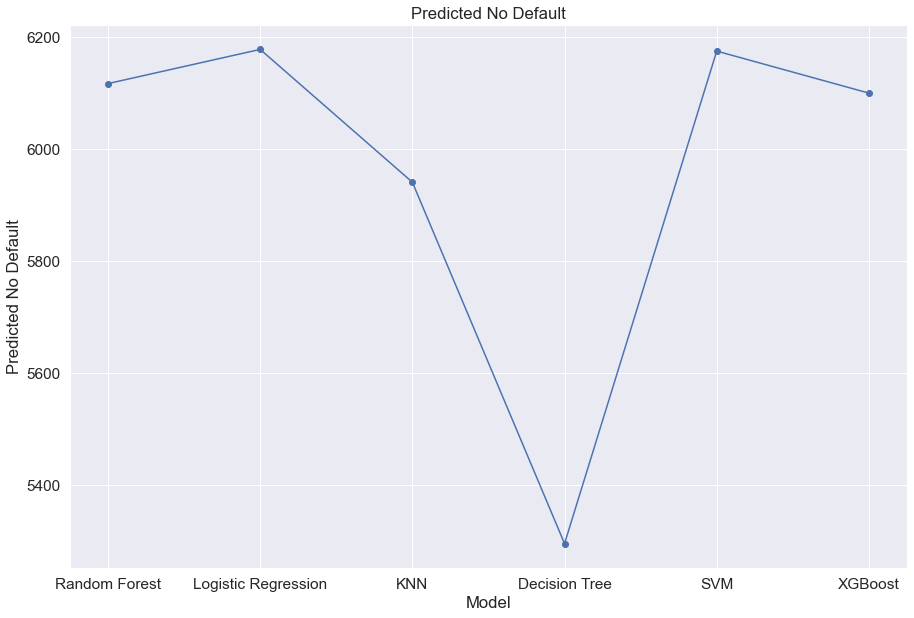

In [44]:
# plot the predicted_no_default, predicted_default, accuracy, auc_lst
plt.figure(figsize=(15,10))
plt.plot(['Random Forest', 'Logistic Regression', 'KNN', 'Decision Tree', 'SVM', 'XGBoost'], predicted_no_default, marker='o')
plt.title('Predicted No Default')
plt.xlabel('Model')
plt.ylabel('Predicted No Default')
plt.show()

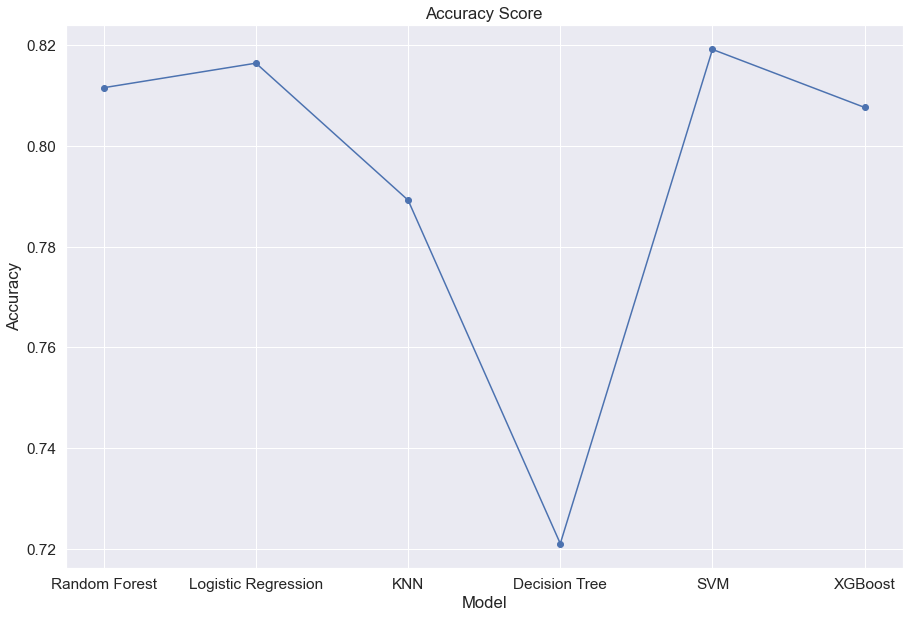

In [42]:
# plot the predicted_no_default, predicted_default, accuracy, auc_lst
plt.figure(figsize=(15,10))
plt.plot(['Random Forest', 'Logistic Regression', 'KNN', 'Decision Tree', 'SVM', 'XGBoost'], accuracy, marker='o')
plt.title('Accuracy Score')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

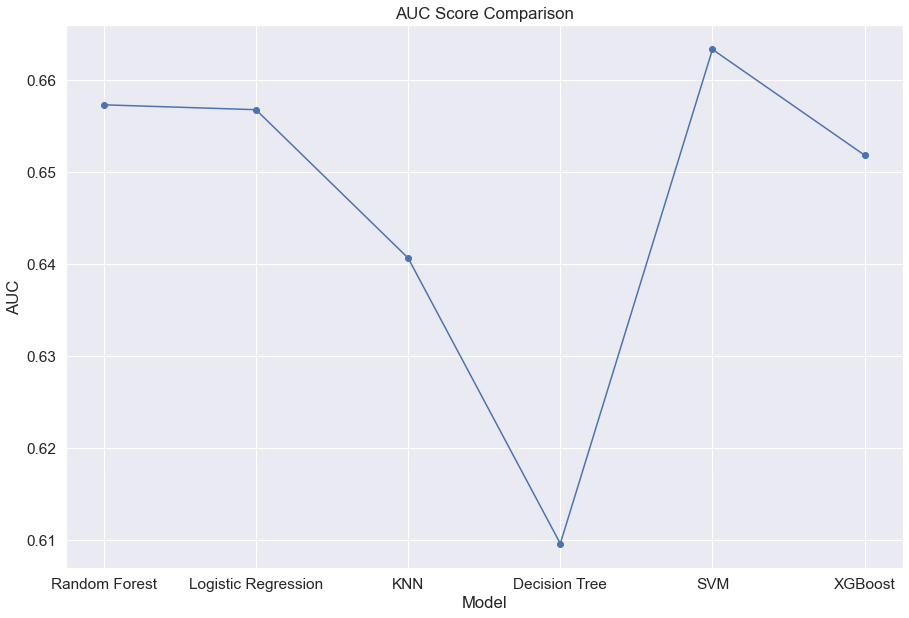

In [41]:
# plot the predicted_no_default, predicted_default, accuracy, auc_lst
plt.figure(figsize=(15,10))
plt.plot(['Random Forest', 'Logistic Regression', 'KNN', 'Decision Tree', 'SVM', 'XGBoost'], auc_lst, marker = 'o')
plt.title('AUC Score Comparison')
plt.xlabel('Model')
plt.ylabel('AUC')
plt.show()